In [42]:
# Modules to import
import argparse

# from simtk.openmm import *
# from simtk.openmm.app import *
from simtk.unit import *
from sys import stdout
import numpy as np

# from openmmtools import forces, alchemy
import pymbar
import matplotlib.pyplot as plt


def make_fe_trace(U_klns, title, kT, lambdas):
    n_trace = 10
    trace_spacing = 1.0 / n_trace
    n_lambdas = len(lambdas)

    free_energy_trace_f = np.zeros([len(U_klns), n_trace, 2], dtype=float)
    free_energy_trace_r = np.zeros([len(U_klns), n_trace, 2], dtype=float)
    indicies_f = []
    indicies_r = []
    for n, U_kln in enumerate(U_klns):
        total_iterations = U_kln.shape[-1]
        for trace_factor in range(n_trace, 0, -1):
            trace_percent = trace_spacing * trace_factor
            j = trace_factor - 1
            kept_iterations = int(trace_percent * total_iterations)
            u_forward = U_kln[:, :, :kept_iterations]
            u_reverse = U_kln[:, :, -1 : -kept_iterations - 1 : -1]
            diff = np.zeros_like(u_forward)
            for i in range(kept_iterations):
                diff[:, :, i] = u_forward[:, :, i] - u_reverse[:, :, -i - 1]
            for energy_sub, storage, indicies_store in [
                (u_forward, free_energy_trace_f, indicies_f),
                (u_reverse, free_energy_trace_r, indicies_r),
            ]:
                N_k = np.zeros(n_lambdas, np.int32)
                for i in range(n_lambdas):
                    N_k[i] = energy_sub.shape[2]  # (indicies)

                # Calculate free energy differences
                mbar = pymbar.MBAR(energy_sub, N_k)
                [fe, dfe, theta_ij] = mbar.compute_free_energy_differences(
                    return_theta=True
                ).values()
                ref_i = 0
                ref_j = -1
                storage[n, j, :] = (
                    (fe[ref_i, ref_j] * kT).in_units_of(kilocalories_per_mole)
                )._value, (
                    (dfe[ref_i, ref_j] * kT).in_units_of(kilocalories_per_mole)
                )._value

    data_f = np.zeros([n_trace, 2])
    data_r = np.zeros([n_trace, 2])
    for i in range(n_trace):
        data_f[i][0] = np.mean(free_energy_trace_f[:, i, 0])
        data_r[i][0] = np.mean(free_energy_trace_r[:, i, 0])
        data_f[i][1] = np.std(free_energy_trace_f[:, i, 0]) / np.sqrt(len(U_klns))
        data_r[i][1] = np.std(free_energy_trace_r[:, i, 0]) / np.sqrt(len(U_klns))

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(111)
    x = np.arange(n_trace + 1)[1:] * trace_spacing * 100
    ax.errorbar(
        x,
        data_f[:, 0],
        yerr=data_f[:, 1],
        ecolor="b",
        elinewidth=0,
        mec="none",
        mew=0,
        linestyle="None",
        zorder=10,
    )
    ax.plot(
        x,
        data_f[:, 0],
        "b-",
        marker="o",
        mec="b",
        mfc="w",
        mew=1.5,
        markersize=10,
        label="Forward",
        zorder=20,
    )

    ax.errorbar(
        x,
        data_r[:, 0],
        yerr=data_r[:, 1],
        ecolor="r",
        elinewidth=0,
        mec="none",
        mew=0,
        linestyle="None",
        zorder=10,
    )
    ax.plot(
        x,
        data_r[:, 0],
        "r-",
        marker="o",
        mec="r",
        mfc="w",
        mew=1.5,
        markersize=10,
        label="Reverse",
        zorder=20,
    )

    y_fill_upper = [data_f[-1, 0] + data_f[-1, 1]]  # * 2
    y_fill_lower = [data_f[-1, 0] - data_f[-1, 1]]  # *2
    xlim = [0, 100]
    ax.fill_between(
        xlim, y_fill_lower, y_fill_upper, color="orchid", zorder=5, alpha=0.5, lw=0
    )
    ax.set_xlim(xlim)

    plt.legend()
    plt.xlabel("% of the simulation time", fontsize=20)
    plt.ylabel(r"$\Delta\ G\ /\ kcal\ mol^{-1}$", fontsize=20)
    plt.title(title, fontsize=20)
    plt.savefig(
        f"{title}_ConvergencePlot.png", dpi=1000, bbox_inches="tight", pad_inches=0.1
    )
    # plt.show()
    return free_energy_trace_f, data_f, fig

In [43]:
U_klns = []
for i in range(1, 4):
    U_klns.append(
        np.load(
            f"/home/will/data_5/Grand/T4L99A/FreeEnergies/Restraints_NEW_LIGS/n-Methylaniline/repeat_{i}/Combined_Ukln.npy"
        )
    )

In [44]:
for i in range(1, 4):
    print(i)

1
2
3


In [45]:
lambdas = np.linspace(0, 1, 15)

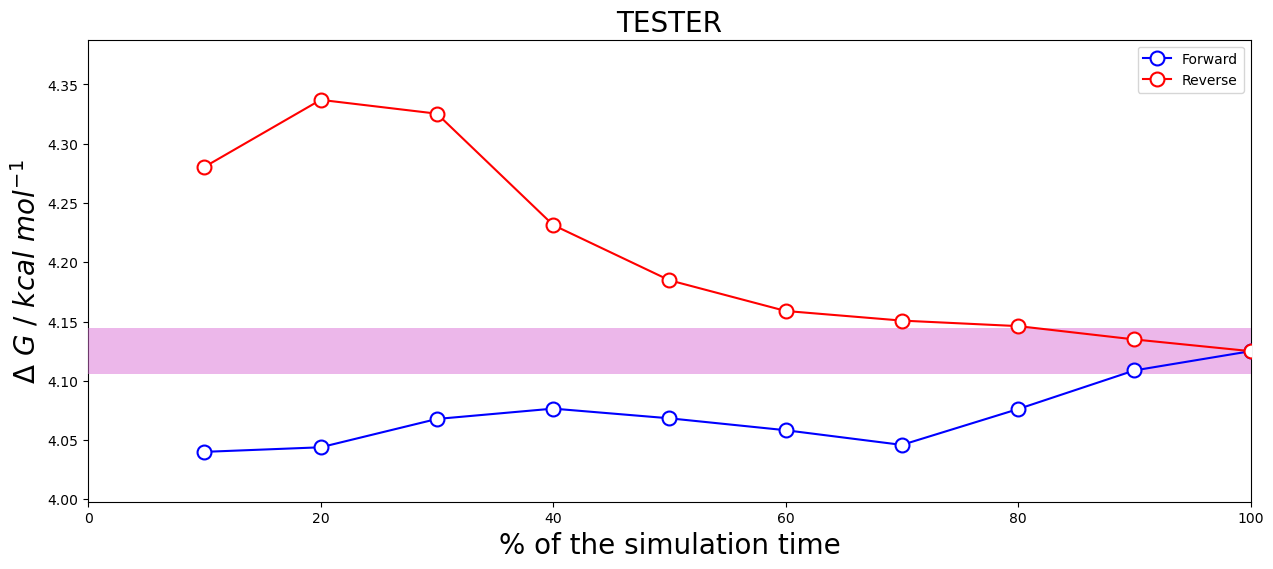

In [46]:
kT = AVOGADRO_CONSTANT_NA * BOLTZMANN_CONSTANT_kB * 298 * kelvin  # Define kT
kT_kcal = kT.in_units_of(kilocalories_per_mole)
free_energy_trace_f, data_f, fig = make_fe_trace(U_klns, "TESTER", kT_kcal, lambdas)

In [41]:
free_energy_trace_f[1]

array([[4.01530492, 0.03275568],
       [4.10776261, 0.02501501],
       [4.13991411, 0.02094524],
       [4.11887134, 0.01793768],
       [4.1050443 , 0.01560161],
       [4.08857917, 0.01398259],
       [4.06096818, 0.01289273],
       [4.09211343, 0.01247717],
       [4.12384399, 0.01209274],
       [4.13593078, 0.01159021]])